<a href="https://colab.research.google.com/github/ebaad4000/python/blob/main/20_18sw_137_Lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Roll number: 20SW009.
Section: 01.
lab: lab#11

## Dataset overview
The dataset has two files. We'll import them both into pandas dataframes:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the ratings dataset
movies = pd.read_csv('/content/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('/content/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [6]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)


def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg Fantasy rating')
    ax.set_ylabel('Avg Comedy rating')


    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_fantasy_rating'], clustered['avg_comedy_rating'], c=clustered['group'], s=20, cmap=cmap)


def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

def sparse_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)


def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    print(genre_ratings)
    genre_ratings.columns = column_names
    return genre_ratings

def get_dataset_3(movies, ratings, genre_ratings):
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action') ]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    # Add action ratings to romance and scifi in dataframe
    genre_ratings_3 = pd.concat([genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_comedy_rating', 'avg_fanatsy_rating', 'avg_action_rating']

    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_comedy_rating'] < b1 - 0.2) & (genre_ratings_3['avg_fantasy_rating'] > b2)) | ((genre_ratings_3['avg_scifi_rating'] < b1) & (genre_ratings_3['avg_romance_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())

    return biased_dataset_3

def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg fantasy rating')
    ax.set_ylabel('Avg comedy rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_fantasy_rating'],
                        point['avg_comedy_rating'],
                        s=size,
                        color=color)

def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]

        d = sort_by_rating_density(d, max_movies, max_users)

        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]

        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)

            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off')
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break

def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)

    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_comedy_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_fantasy_rating'] > score_limit_2)) | ((genre_ratings['avg_fantasy_rating'] < score_limit_1) & (genre_ratings['avg_comedy_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

## Comedy vs. Fantasy
Let's start by taking a subset of users, and seeing what their preferred genres are. We're hiding the most data preprocessing in helper functions so the focus is on the topic of clustering. It would be useful if you skim helper.py to see how these helper functions are implemented after finishing this notebook.

In [7]:
# Calculate the average rating of romance and scifi movies

genre_ratings = get_genre_ratings(ratings, movies, ['Comedy', 'Fantasy'], ['avg_comedy_rating', 'avg_fantasy_rating'])
genre_ratings.head()

     rating  rating
1      4.28    4.30
2      4.00     NaN
3      1.00    3.38
4      3.51    3.68
5      3.47    4.14
..      ...     ...
607    3.33    3.57
608    2.74    3.00
609    3.29    3.00
610    3.73    3.59
549     NaN    3.17

[610 rows x 2 columns]


,avg_comedy_rating,avg_fantasy_rating
1,4.28,4.30
2,4.00,NaN
3,1.00,3.38
4,3.51,3.68
5,3.47,4.14


In [8]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  151


,index,avg_comedy_rating,avg_fantasy_rating
0,3,1.00,3.38
1,7,3.16,3.07
2,11,3.42,2.00
3,13,3.27,3.00
4,14,2.71,1.00


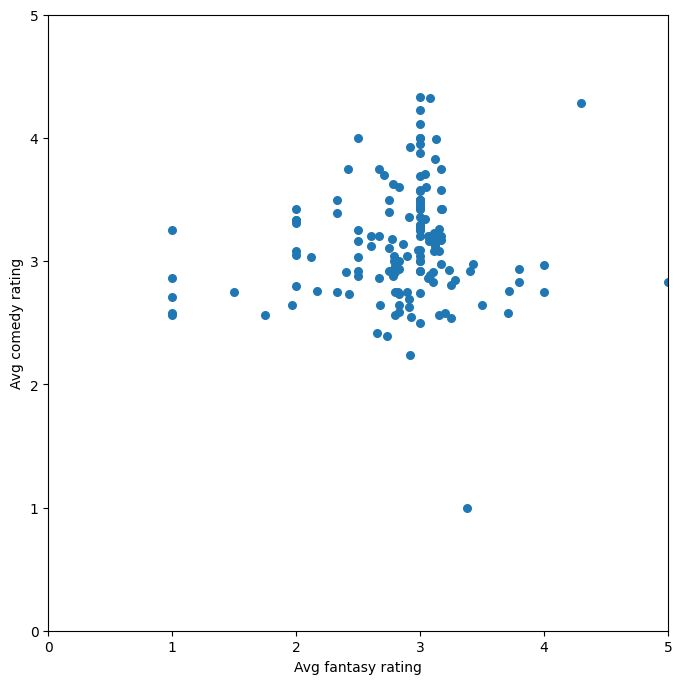

In [9]:
%matplotlib inline

draw_scatterplot(biased_dataset['avg_fantasy_rating'],'Avg fantasy rating', biased_dataset['avg_comedy_rating'], 'Avg comedy rating')

In [10]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_fantasy_rating','avg_comedy_rating']].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


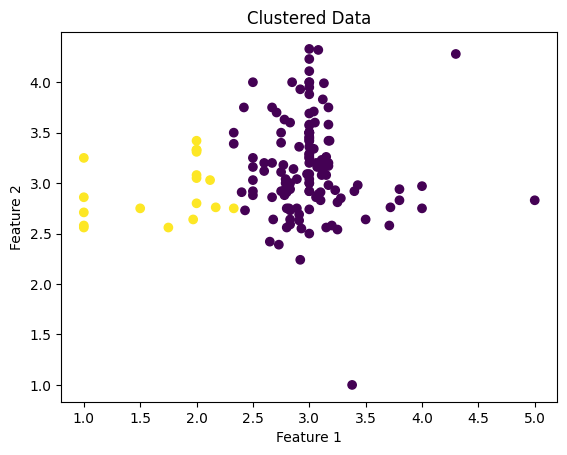

In [10]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a function to plot the clusters
def draw_clusters(data, predictions):
    plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis')
    plt.title("Clustered Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Assuming X is your dataset with missing values
# Option 1: Impute missing values (fill NaN values with mean)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Option 2: Remove rows with missing values
# X_cleaned = X.dropna()

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X_imputed)  # Use X_imputed if you chose option 1, or X_cleaned if you chose option 2

# Plot the clusters
draw_clusters(X_imputed, predictions)  # Use X_imputed if you chose option 1, or X_cleaned if you chose option 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


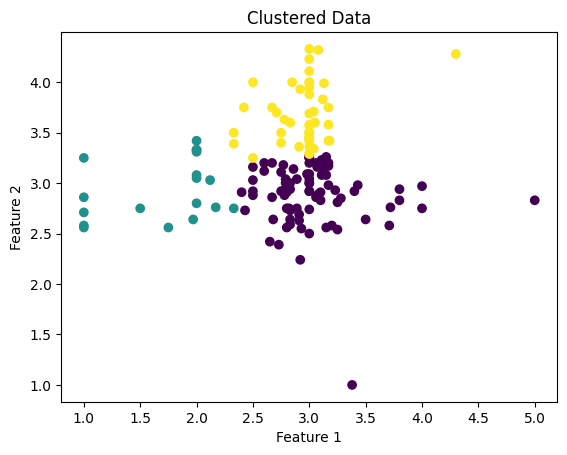

In [11]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Define a function to plot the clusters
def draw_clusters(data, predictions):
    plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis')
    plt.title("Clustered Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Assuming X is your dataset with missing values
# Impute missing values (fill NaN values with mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X_imputed)

# Plot the clusters
draw_clusters(X_imputed, predictions_2)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


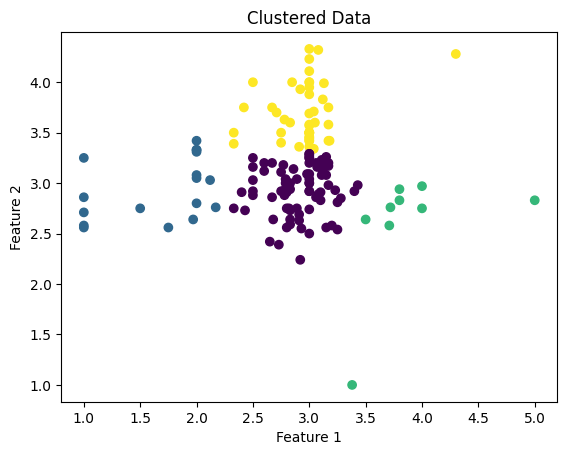

In [12]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Define a function to plot the clusters
def draw_clusters(data, predictions):
    plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap='viridis')
    plt.title("Clustered Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Assuming X is your dataset with missing values
# Impute missing values (fill NaN values with mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create an instance of KMeans to find four clusters
kmeans_3 = KMeans(n_clusters=4)

# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X_imputed)

# Plot the clusters
draw_clusters(X_imputed, predictions_3)


In [13]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Define a function to calculate clustering errors
def clustering_errors(k, data):
    # Impute missing values (fill NaN values with mean)
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)

    # Create an instance of KMeans with k clusters
    kmeans = KMeans(n_clusters=k)

    # Fit the KMeans model to the data and calculate the error
    kmeans.fit(data_imputed)
    return kmeans.inertia_

# Choose the range of k values to test
possible_k_values = range(2, len(X) + 1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [14]:
# Optional: Look at the values of K vs the silhouette score of running K-means with that value of k
list(zip(possible_k_values, errors_per_k))

[(2, 52.949810180872305),
 (7, 13.907095501812412),
 (12, 6.126038435795536),
 (17, 3.6327413564550266),
 (22, 2.4634911038701306),
 (27, 1.6358573282783886),
 (32, 1.2214596939682543),
 (37, 0.9218307377533577),
 (42, 0.6833787263247864),
 (47, 0.5730904663247864),
 (52, 0.4304535714285713),
 (57, 0.3468614251851851),
 (62, 0.2763035195767196),
 (67, 0.20785416666666662),
 (72, 0.159115),
 (77, 0.12908666666666674),
 (82, 0.10170333333333337),
 (87, 0.07698000000000005),
 (92, 0.05662833333333334),
 (97, 0.043371666666666725),
 (102, 0.03095500000000003),
 (107, 0.021071666666666697),
 (112, 0.014696666666666709),
 (117, 0.009900000000000058),
 (122, 0.005466666666666701),
 (127, 0.0025333333333333466),
 (132, 0.0010000000000000106),
 (137, 0.00015000000000000248),
 (142, 0.0),
 (147, 0.0)]

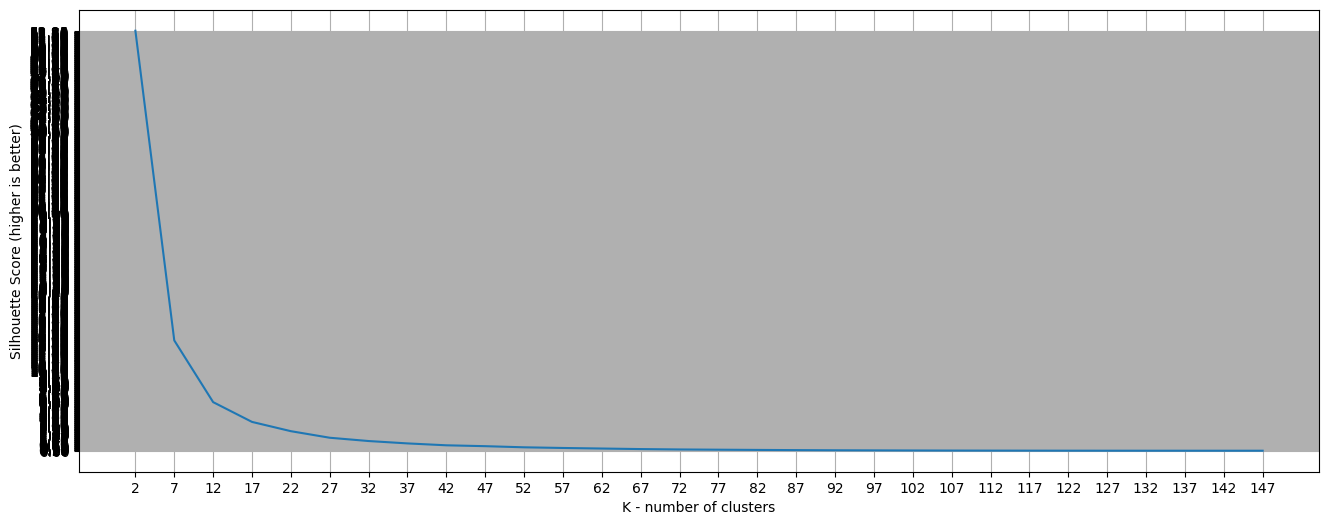

In [15]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


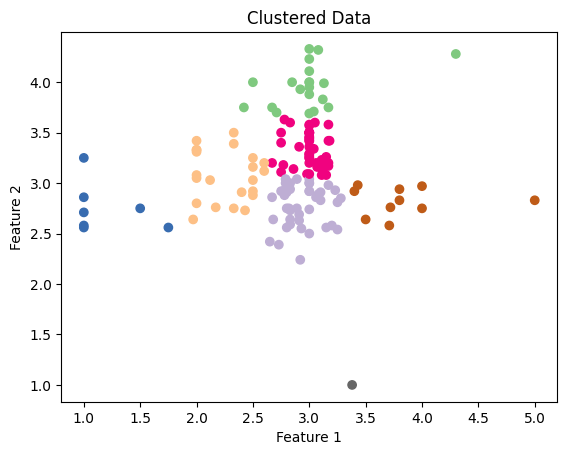

In [16]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Define a function to plot the clusters
def draw_clusters(data, predictions, cmap='viridis'):
    plt.scatter(data[:, 0], data[:, 1], c=predictions, cmap=cmap)
    plt.title("Clustered Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Assuming X is your dataset with missing values
# Impute missing values (fill NaN values with mean)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)

# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X_imputed)

# Plot the clusters
draw_clusters(X_imputed, predictions_4, cmap='Accent')


In [18]:
biased_dataset_3_genres = get_genre_ratings(ratings, movies,
                                                     ['Comedy', 'Fantasy', 'Action'],
                                                     ['avg_comedy_rating', 'avg_fantasy_rating', 'avg_action_rating'])
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

     rating  rating  rating
1      4.28    4.30    4.32
2      4.00     NaN    3.95
3      1.00    3.38    3.57
4      3.51    3.68    3.32
5      3.47    4.14    3.11
..      ...     ...     ...
607    3.33    3.57    3.72
608    2.74    3.00    3.33
609    3.29    3.00    3.09
610    3.73    3.59    3.60
549     NaN    3.17    3.83

[610 rows x 3 columns]
Number of records:  150


,index,avg_comedy_rating,avg_fantasy_rating,avg_action_rating
0,3,1.00,3.38,3.57
1,7,3.16,3.07,3.26
2,11,3.42,2.00,3.54
3,13,3.27,3.00,4.20
4,14,2.71,1.00,3.33


In [20]:
X_with_action = biased_dataset_3_genres[['avg_comedy_rating',
                                         'avg_fantasy_rating',
                                         'avg_action_rating']].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


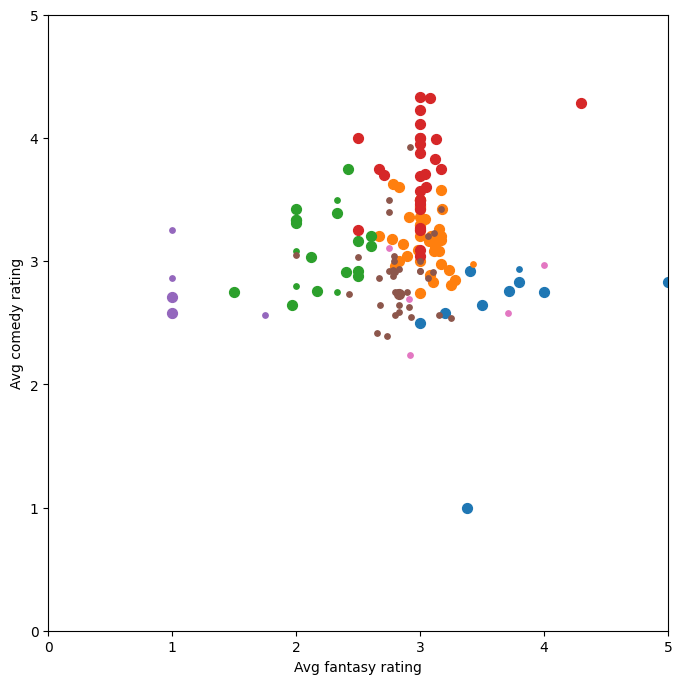

In [22]:
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

# use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

We're still using the x and y axes for scifi and romance respectively. We are using the size of the dot to roughly code the 'action' rating (large dot for avg ratings over than 3, small dot otherwise).

We can start seeing the added genre is changing how the users are clustered. The more data we give to k-means, the more similar the tastes of the people in each group would be. Unfortunately, though, we lose the ability to visualize what's going on past two or three dimensions if we continue to plot it this way. In the next section, we'll start using a different kind of plot to be able to see clusters with up to fifty dimensions.

## Movie-level Clustering
Now that we've established some trust in how k-means clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies. To do that, we'll shape the dataset in the form of userId vs user rating for each movie. For example, let's look at a subset of the dataset:

In [23]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


<ipython-input-6-3485cf37a53b>:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


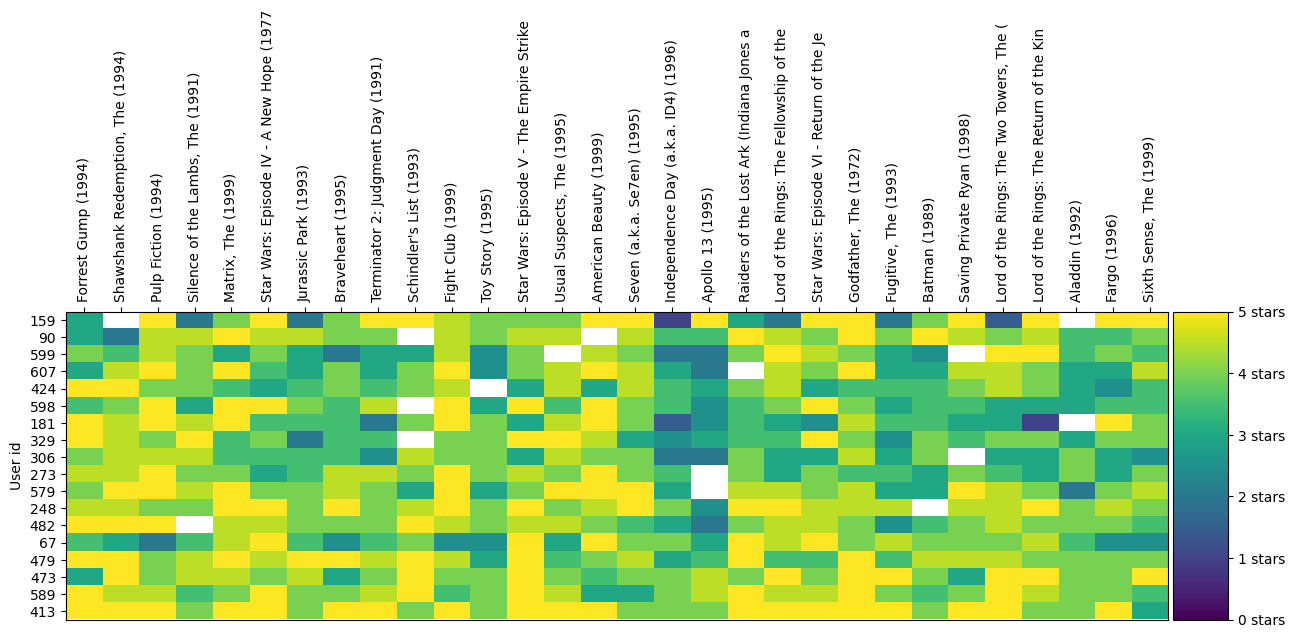

In [34]:
draw_movies_heatmap(most_rated_movies_users_selection)

In [23]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

<ipython-input-5-3485cf37a53b>:159: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


In [24]:
from scipy.sparse import coo_matrix

# Assuming most_rated_movies_1k is a DataFrame
sparse_ratings = coo_matrix(most_rated_movies_1k.values)

## Let's cluster!
With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20 (A better way to pick k is as illustrated above with the elbow method. That would take some processing time to run, however.):

In [25]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from scipy.sparse import csr_matrix

# Assuming sparse_ratings is a sparse matrix
imputer = SimpleImputer(strategy='constant', fill_value=0)
sparse_ratings_imputed = csr_matrix(imputer.fit_transform(sparse_ratings))

# Use K-means clustering
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings_imputed)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [36]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

NameError: ignored

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colors you'll be able to trace in that cluster.
* It's super interesting to spot trends in clusters:
 * Some clusters are more sparse than others, containing people who probably watch and rate less movies than in other clusters.
 * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movoies deserves 2-3 stars.
 * Note how the movies change in every cluster. The graph filters the data to only show the most rated movies, and then sorts them by average rating.
 * Can you track where the Lord of the Rings movies appear in each cluster? What about Star Wars movies?
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings. This is likely one of the reasons for Netflix switching from a stars-based ratings to a thumbs-up/thumbs-down rating. A rating of four stars means different things to different people.
* We did a few things to make the clusters visibile (filtering/sorting/slicing). This is because datasets like this are "sparse" and most cells do not have a value (because most people did not watch most movies).

## Prediction
Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

Let's first pick a cluster:

In [35]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

NameError: ignored

In [28]:
cluster.fillna('').head()

,Forrest Gump (1994),Full Metal Jacket (1987),Lost in Translation (2003),"40-Year-Old Virgin, The (2005)",Unbreakable (2000),Pirates of the Caribbean: Dead Man's Chest (2006),Bruce Almighty (2003),Harry Potter and the Goblet of Fire (2005),Big Fish (2003),Shutter Island (2010),...,"Amazing Spider-Man, The (2012)",Under Siege 2: Dark Territory (1995),Sweeney Todd: The Demon Barber of Fleet Street (2007),Resident Evil (2002),Limitless (2011),"Insider, The (1999)",Final Fantasy: The Spirits Within (2001),Boogie Nights (1997),Life of Pi (2012),City Slickers (1991)
1,5.0,5.0,4.0,4.0,5.0,3.0,4.0,3.5,4.0,5.0,...,,,,,,,3.0,,,3.5
0,4.5,4.0,4.0,3.5,4.0,3.0,3.0,3.0,4.5,4.5,...,3.0,3.5,3.0,3.0,3.5,4.0,,4.0,4.0,


In [1]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
# Pick a movie from the table above since we're looking at a subset
movie_name = 'Terminator 2: Judgment Day (1991)'

cluster[movie_name].mean()

NameError: ignored

And this would be our prediction for how she'd rate the movie.

## Recommendation
Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie  we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset.


In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Matrix, The (1999)                                           3.955357
Fight Club (1999)                                            4.156250
Pulp Fiction (1994)                                          4.312500
Shawshank Redemption, The (1994)                             4.377778
Silence of the Lambs, The (1991)                             4.240000
Forrest Gump (1994)                                          3.954545
American Beauty (1999)                                       4.055556
Godfather, The (1972)                                        4.300000
Schindler's List (1993)                                      4.176471
Inception (2010)                                             3.921875
Lord of the Rings: The Fellowship of the Ring, The (2001)    4.194444
Lord of the Rings: The Return of the King, The (2003)        4.138889
Usual Suspects, The (1995)                                   4.189189
Fargo (1996)                                                 4.187500
Star Wars: Episode I

In [ ]:
# Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()"
# and pick one of the user ids (the first column in the table)
user_id = 1

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Raging Bull (1980)                                                 4.550000
Boot, Das (Boat, The) (1981)                                       4.500000
Sting, The (1973)                                                  4.500000
African Queen, The (1951)                                          4.500000
Wizard of Oz, The (1939)                                           4.450000
Bridge on the River Kwai, The (1957)                               4.437500
City of Lost Children, The (Cité des enfants perdus, La) (1995)    4.437500
North by Northwest (1959)                                          4.384615
Into the Wild (2007)                                               4.375000
Election (1999)                                                    4.375000
Heat (1995)                                                        4.375000
Monty Python's Life of Brian (1979)                                4.343750
Departed, The (2006)                                               4.340909
City of God 